Runs two basic convolutional networks on the pilot dataset.

The regression modules are implemented in cs273b-project/dragonn

To make changes to this dragonn-

\$ sudo su

\$ source activate regression_dragonn

\$ cd cs273b-project/dragonn

\$ python setup.py install

In [1]:
from dragonn import models

from collections import OrderedDict
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from dragonn.hyperparameter_search import HyperparameterSearcher, RandomSearch

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Read in the pilot data.
- Samples are sequences that will be one hot encoded
- Try and predict the normalized values. **I couldn't figure out how to do regression with Dragonn, so I just rounded the values to 0 or 1 based on the median.**

In [2]:
key_to_seq = OrderedDict()

with open("../data/Pilot_counts_sequences/PilotDesign.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        key_to_seq[key] = seq

In [3]:
key_to_normalized_K562_Rep1 = {}
key_to_normalized_K562_Rep2 = {}

with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep1_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep1[key] = val
            
with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep2_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep2[key] = val

# Check that the sequence and value keys line up.
assert set(key_to_normalized_K562_Rep1.keys()) == set(key_to_seq.keys())
assert set(key_to_normalized_K562_Rep2.keys()) == set(key_to_seq.keys())

In [4]:
# One hot encode DNA sequences the standard way.
def one_hot_encode_seq(seq):
    bases = ['A', 'T', 'C', 'G']
    # Gotta be ready for when we discover a new base.
    result = np.zeros((4, len(seq)))
    
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1

    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, 4, len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
    
    return result

In [5]:
X = seqs_to_encoded_matrix(key_to_seq.values())

In [6]:
K562_Rep1_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep1[key], 
        key_to_seq.keys()
    )
).reshape(-1, 1)

K562_Rep2_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep2[key], 
        key_to_seq.keys()
    )
).reshape(-1, 1)

y = (K562_Rep1_y + K562_Rep2_y)/2

In [7]:
# Just take the last 100 to be the validation set.
X_train = X[:-100,:,:,:]
y_train = y[:-100,:]

X_valid = X[-100:,:,:,:]
y_valid = y[-100:,:]

Basic regression model that optimizes for RMS error using RMSProp. Train and plot the train and validation loss.

In [8]:
hyperparameter_search = True
multi_filter = False

if hyperparameter_search:
    seq_length = 145
    num_epochs = 100
    num_hyperparameter_trials = 2

    fixed_hyperparameters = {'seq_length': seq_length, 'num_epochs': num_epochs, 'verbose':0}

    grid = {'num_filters': ((5, 100), (5, 100), (5, 100)), 'pool_width': (5, 40),
            'conv_width': ((6, 20), (6, 20), (6, 20)), 'dropout': (0, 0.5)}
    
    searcher = HyperparameterSearcher(models.SequenceDNN_Regression, fixed_hyperparameters, grid, 
                                      X_train, y_train, validation_data=(X_valid, y_valid),
                                      metric='Mean Squared Error', backend=RandomSearch)
    
    searcher.search(num_hyperparameter_trials)
    print('Best hyperparameters: {}'.format(searcher.best_hyperparameters))
    model = searcher.best_model
    
elif multi_filter:
    model = models.SequenceDNN_Regression(
        seq_length=X_train.shape[3],
        num_filters=[50],
        conv_width=[60],
        pool_width=45,
        num_epochs=1000,
        dropout=0.1,
        num_tasks=y_train.shape[1]
    )
    
else:
    model = models.SequenceDNN_Regression(
        seq_length=X_train.shape[3],
        num_filters=[1],
        conv_width=[45],
        pool_width=45,
        num_tasks=y_train.shape[1]
    )

Trial 1
Hyperparameters:  {'dropout': 0, 'num_filters': array([73, 29, 91]), 'pool_width': 20, 'conv_width': array([15, 18, 16])} 

Trial 2
Hyperparameters:  {'dropout': 0, 'num_filters': array([33, 47, 91]), 'pool_width': 24, 'conv_width': array([15,  6,  9])} 

Best hyperparameters: {'dropout': 0, 'num_filters': array([73, 29, 91]), 'pool_width': 20, 'conv_width': array([15, 18, 16])}


In [9]:
model.plot_architecture(output_file='pilot_regression_arch.png')

In [10]:
model.train(X_train, y_train, (X_valid, y_valid))

In [11]:
def print_loss(model, metric):
    train_losses, valid_losses = [np.array([epoch_metrics[metric] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    train_losses = train_losses.mean(axis=1)
    valid_losses = valid_losses.mean(axis=1)

    f = plt.figure(figsize=(10, 4))
    ax = f.add_subplot(1, 1, 1)
    
    ax.plot(range(len(train_losses)), train_losses, label='Training',lw=4)
    ax.plot(range(len(train_losses)), valid_losses, label='Validation', lw=4)
    
    min_loss_indx = min(enumerate(valid_losses), key=lambda x: x[1])[0]
#     ax.plot([min_loss_indx, min_loss_indx], [0, 1.0], 'k--', label='Early Stop')
    ax.legend(loc="best")
    ax.set_ylabel(metric)
#     ax.set_ylim((-1.0,1.0))
    ax.set_xlabel("Epoch")
    plt.show()

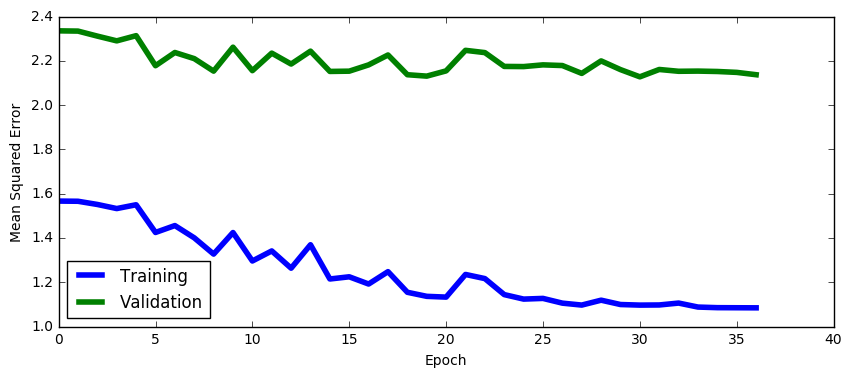

In [12]:
metric = "Mean Squared Error"
print_loss(model, metric)